---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [215]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime
from datetime import timedelta

#from sklearn.preprocessing import LabelEncoder
#%matplotlib inline

def blight_model():
    
    def time_gap(hearing_date_str, ticket_issued_date_str):
        from datetime import datetime
        from datetime import timedelta
        if not hearing_date_str or type(hearing_date_str)!=str: return 73
        hearing_date = datetime.strptime(hearing_date_str, "%Y-%m-%d %H:%M:%S")
        ticket_issued_date = datetime.strptime(ticket_issued_date_str, "%Y-%m-%d %H:%M:%S")

        gap = hearing_date - ticket_issued_date
        return gap.days
    
    train_data = pd.read_csv('train.csv', encoding = 'ISO-8859-1',low_memory=False)
    test_data = pd.read_csv('test.csv',encoding = 'ISO-8859-1',low_memory=False)
    isnan=train_data['compliance'].isnull()
    train_data=train_data[-isnan]
    
    address =  pd.read_csv('addresses.csv')
    latlons = pd.read_csv('latlons.csv')
    
    address = address.set_index('address').join(latlons.set_index('address'), how='left')
    
    train_data = train_data.set_index('ticket_id').join(address.set_index('ticket_id'))
    test_data = test_data.set_index('ticket_id').join(address.set_index('ticket_id'))
    
    train_data.loc[89535,['lat','lon']]=[42.446540,-83.023300]  #2 record has nan on lat and lon, manually insert value
    
    #train_data = train_data[~train_data['hearing_date'].isnull()]
    #train_data['hearing_date']=pd.to_datetime(train_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
    #train_data['ticket_issued_date']=pd.to_datetime(train_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')
    #test_data['hearing_date']=pd.to_datetime(test_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
    #test_data['ticket_issued_date']=pd.to_datetime(test_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')
    
    train_data['time_gap'] = train_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    test_data['time_gap'] = test_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
    
    #train_data.loc[train_data['time_gap'].isnull(),'time_gap']=train_data['time_gap'].mean()
    #test_data.loc[test_data['time_gap'].isnull(),'time_gap']=test_data['time_gap'].mean()
    
    feature_to_be_splitted = ['agency_name', 'state', 'disposition']
    train_data.lat.fillna(method='pad', inplace=True)
    train_data.lon.fillna(method='pad', inplace=True)
    train_data.state.fillna(method='pad', inplace=True)

    test_data.lat.fillna(method='pad', inplace=True)
    test_data.lon.fillna(method='pad', inplace=True)
    test_data.state.fillna(method='pad', inplace=True)
    train_data = pd.get_dummies(train_data, columns=feature_to_be_splitted)
    test_data = pd.get_dummies(test_data, columns=feature_to_be_splitted)
    list_to_remove_train = [
        'balance_due',
        'collection_status',
        'compliance_detail',
        'payment_amount',
        'payment_date',
        'payment_status'
    ]
    list_to_remove_all = ['fine_amount', 'violator_name', 'zip_code', 'country', 'city',
                          'inspector_name', 'violation_street_number', 'violation_street_name',
                          'violation_zip_code', 'violation_description',
                          'mailing_address_str_number', 'mailing_address_str_name',
                          'non_us_str_code',
                          'ticket_issued_date', 'hearing_date', 'grafitti_status', 'violation_code']
    train_data.drop(list_to_remove_train, axis=1, inplace=True)
    train_data.drop(list_to_remove_all, axis=1, inplace=True)
    test_data.drop(list_to_remove_all, axis=1, inplace=True)
    
    train_features = train_data.columns.drop('compliance')
    train_features_set = set(train_features)
    
    for feature in set(train_features):
        if feature not in test_data:
            train_features_set.remove(feature)
    train_features = list(train_features_set)

    
    train_target=train_data['compliance']
    X_train=train_data[train_features]
    X_test=test_data[train_features]
    
    #X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, random_state=0)
    clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, random_state = 0).fit(X_train, train_target)
    #y_score_gb = clf.fit(X_train, train_target).decision_function(X_test)
    test_proba = clf.predict_proba(X_test)[:,1]
    prob = pd.Series(test_proba, index = test_data.index)
    #fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)
    #roc_auc_gb = auc(fpr_gb, tpr_gb)

    """
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_gb, tpr_gb, lw=3, label='GB ROC curve (area = {:0.2f})'.format(roc_auc_gb))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    """
    
    """
    X_train = train_data[train_features]
    y_train = train_data.compliance
    X_test = test_data[train_features]
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = MLPClassifier(hidden_layer_sizes = [100, 10], alpha = 5,
                       random_state = 0, solver='lbfgs', verbose=0)
    clf.fit(X_train_scaled, y_train)

    test_proba = clf.predict_proba(X_test_scaled)[:,1]

    
    test_df = pd.read_csv('test.csv', encoding = "ISO-8859-1")
    test_df['compliance'] = test_proba
    test_df.set_index('ticket_id', inplace=True)
    """
    return prob

In [216]:
print(blight_model())

ticket_id
284932    0.058623
285362    0.042124
285361    0.058623
285338    0.060005
285346    0.060005
285345    0.060005
285347    0.060005
285342    0.607735
285530    0.043135
284989    0.043135
285344    0.060005
285343    0.043135
285340    0.043135
285341    0.060005
285349    0.060005
285348    0.060005
284991    0.043135
285532    0.043135
285406    0.042124
285001    0.043135
285006    0.043135
285405    0.042124
285337    0.042124
285496    0.058623
285497    0.058623
285378    0.042124
285589    0.042124
285585    0.058623
285501    0.058623
285581    0.042124
            ...   
376367    0.042124
376366    0.045153
376362    0.153488
376363    0.153488
376365    0.042124
376364    0.045153
376228    0.045153
376265    0.045153
376286    0.165487
376320    0.045153
376314    0.045153
376327    0.165487
376385    0.165487
376435    0.596870
376370    0.607735
376434    0.058623
376459    0.058623
376478    0.042124
376473    0.045153
376484    0.042124
376482    0.042124
37

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.metrics import roc_curve, auc

In [145]:
pd.set_option('display.max_columns', None)

In [146]:
train_data = pd.read_csv('train.csv', encoding = 'ISO-8859-1',low_memory=False)
test_data = pd.read_csv('test.csv',encoding = 'ISO-8859-1',low_memory=False)
isnan=train_data['compliance'].isnull()
train_data=train_data[-isnan]


In [174]:
train_data.shape

(159880, 13)

In [175]:
test_data.shape

(61001, 12)

In [155]:
address =  pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')

In [156]:
address = address.set_index('address').join(latlons.set_index('address'), how='left')
train_data = train_data.set_index('ticket_id').join(address.set_index('ticket_id'))
test_data = test_data.set_index('ticket_id').join(address.set_index('ticket_id'))

In [157]:
train_data.loc[89535,['lat','lon']]=[42.446540,-83.023300]  #2 record has nan on lat and lon, manually insert value

In [164]:
train_data['hearing_date']=pd.to_datetime(train_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
train_data['ticket_issued_date']=pd.to_datetime(train_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')
test_data['hearing_date']=pd.to_datetime(test_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
test_data['ticket_issued_date']=pd.to_datetime(test_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')

In [165]:
def time_gap(hearing_date, ticket_issued_date):
    gap = hearing_date - ticket_issued_date
    return gap.days


In [166]:
train_data['time_gap'] = train_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
test_data['time_gap'] = test_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
train_data.loc[train_data['time_gap'].isnull(),'time_gap']=train_data['time_gap'].mean()
test_data.loc[test_data['time_gap'].isnull(),'time_gap']=test_data['time_gap'].mean()  

In [167]:
feature_to_be_splitted = ['agency_name', 'state', 'disposition']
train_data.lat.fillna(method='pad', inplace=True)
train_data.lon.fillna(method='pad', inplace=True)
train_data.state.fillna(method='pad', inplace=True)

test_data.lat.fillna(method='pad', inplace=True)
test_data.lon.fillna(method='pad', inplace=True)
test_data.state.fillna(method='pad', inplace=True)


In [152]:
list_to_remove_train = [
        'balance_due',
        'collection_status',
        'compliance_detail',
        'payment_amount',
        'payment_date',
        'payment_status'
]
list_to_remove_all = ['fine_amount', 'violator_name', 'zip_code', 'country', 'city',
                          'inspector_name', 'violation_street_number', 'violation_street_name',
                          'violation_zip_code', 'violation_description',
                          'mailing_address_str_number', 'mailing_address_str_name',
                          'non_us_str_code',
                          'ticket_issued_date', 'hearing_date', 'grafitti_status', 'violation_code']


In [153]:
train_data.drop(columns=list_to_remove_train, inplace=True)

In [173]:

train_data.drop(columns=list_to_remove_all, inplace=True)
test_data.drop(columns=list_to_remove_all, inplace=True)

In [179]:
train_data = pd.get_dummies(train_data, columns=feature_to_be_splitted)
test_data = pd.get_dummies(test_data, columns=feature_to_be_splitted)

In [185]:
train_features = train_data.columns.drop('compliance')
train_features_set = set(train_features)

In [186]:
for feature in set(train_features):
    if feature not in test_data:
        train_features_set.remove(feature)
train_features = list(train_features_set)
    
X_train = train_data[train_features]
y_train = train_data.compliance
X_test = test_data[train_features]

In [188]:
X_test.shape

(61001, 74)

In [189]:
clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, random_state = 0).fit(X_train, y_train)

In [190]:
y_score_gb = clf.decision_function(X_test)

In [191]:
y_score_gb

array([-2.77621927, -3.12410429, -2.77621927, ..., -2.77621927,
       -2.77621927,  0.25402999])

In [208]:
type((X_test.index,y_score_gb))

tuple

In [192]:
test_proba = clf.predict_proba(X_test)[:,1]

In [209]:
bm = pd.Series(test_proba, index = test_data.index)

In [210]:
bm

ticket_id
284932    0.058623
285362    0.042124
285361    0.058623
285338    0.060005
285346    0.060005
285345    0.060005
285347    0.060005
285342    0.607735
285530    0.043135
284989    0.043135
285344    0.060005
285343    0.043135
285340    0.043135
285341    0.060005
285349    0.060005
285348    0.060005
284991    0.043135
285532    0.043135
285406    0.042124
285001    0.043135
285006    0.043135
285405    0.042124
285337    0.042124
285496    0.058623
285497    0.058623
285378    0.042124
285589    0.042124
285585    0.058623
285501    0.058623
285581    0.042124
            ...   
376367    0.042124
376366    0.045153
376362    0.153488
376363    0.153488
376365    0.042124
376364    0.045153
376228    0.045153
376265    0.045153
376286    0.165487
376320    0.045153
376314    0.045153
376327    0.165487
376385    0.165487
376435    0.596870
376370    0.607735
376434    0.058623
376459    0.058623
376478    0.042124
376473    0.045153
376484    0.042124
376482    0.042124
37

(array([2.1819e+04, 2.9034e+04, 0.0000e+00, 0.0000e+00, 7.0000e+00,
        4.0000e+00, 5.2000e+01, 2.8800e+02, 1.7100e+02, 1.2010e+03,
        4.2090e+03, 1.8000e+01, 7.0000e+01, 2.2000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00, 1.0000e+01,
        0.0000e+00, 0.0000e+00, 7.5000e+01, 3.3000e+01, 4.6200e+02,
        2.4600e+02, 0.0000e+00, 1.3600e+02, 2.6770e+03, 4.6100e+02]),
 array([0.04212385, 0.05385686, 0.06558986, 0.07732286, 0.08905586,
        0.10078886, 0.11252186, 0.12425486, 0.13598787, 0.14772087,
        0.15945387, 0.17118687, 0.18291987, 0.19465287, 0.20638588,
        0.21811888, 0.22985188, 0.24158488, 0.25331788, 0.26505088,
        0.27678388, 0.28851689, 0.30024989, 0.

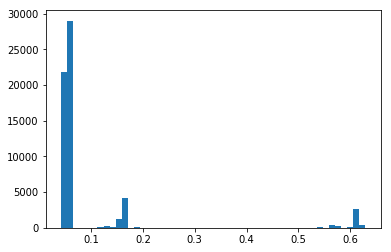

In [197]:
plt.hist(test_proba,50)

In [ ]:
traincol=train_data.columns
testcol=test_data.columns

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
for feature in testcol:
        if feature not in traincol:
            print(feature)

In [ ]:
for feature in traincol:
        if feature not in testcol:
            print(feature)

In [126]:
train_target=train_data['compliance']
train_data.drop(columns='compliance', inplace=True)

In [200]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, random_state=0)

In [201]:
clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, random_state = 0)
clf.fit(X_train1, y_train1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [202]:
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train1, y_train1)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test1, y_test1)))

Accuracy of GBDT classifier on training set: 0.94
Accuracy of GBDT classifier on test set: 0.94


C:\Users\dwang\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


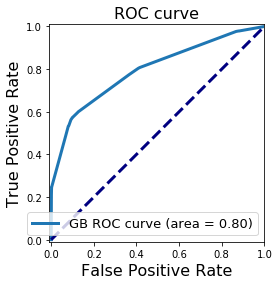

In [203]:
from sklearn.metrics import roc_curve, auc
y_score_gb = clf.fit(X_train1, y_train1).decision_function(X_test1)
fpr_gb, tpr_gb, _ = roc_curve(y_test1, y_score_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gb, tpr_gb, lw=3, label='GB ROC curve (area = {:0.2f})'.format(roc_auc_gb))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [138]:
test_score_gb = clf.fit(train_data, train_target).decision_function(test_data)


ValueError: Number of features of the model must match the input. Model n_features is 77 and input n_features is 78 

In [139]:
traincol=train_data.columns
testcol=test_data.columns

In [140]:
for feature in traincol:
        if feature not in testcol:
            print(feature)

agency_name_Health Department
agency_name_Neighborhood City Halls
state_BL


In [141]:
for feature in testcol:
        if feature not in traincol:
            print(feature)

disposition_Responsible (Fine Waived) by Admis
disposition_Responsible - Compl/Adj by Default
disposition_Responsible - Compl/Adj by Determi
disposition_Responsible by Dismissal


In [142]:
len(traincol)

77

In [143]:
len(testcol)

78

In [43]:
train_data['hearing_date'].isnull().sum()

227

In [47]:
train_data['hearing_date']=pd.to_datetime(train_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
train_data['ticket_issued_date']=pd.to_datetime(train_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')

In [50]:
test_data['hearing_date']=pd.to_datetime(test_data['hearing_date'], format='%Y-%m-%d %H:%M:%S')
test_data['ticket_issued_date']=pd.to_datetime(test_data['ticket_issued_date'], format='%Y-%m-%d %H:%M:%S')

In [65]:
(train_data.loc[89535,'hearing_date']-train_data.loc[89535,'ticket_issued_date']).days

60

In [71]:
train_data['time_gap'] = train_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)
test_data['time_gap'] = test_data.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis=1)


In [81]:
train_data.loc[train_data['time_gap'].isnull(),'time_gap']=train_data['time_gap'].mean()

In [84]:
train_data.loc[21422,:]

agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                 Steele, Jonathan
violator_name                                              PROPERTIES LLC, JACO
violation_street_number                                                   12659
violation_street_name                                                  WOODMONT
violation_zip_code                                                          NaN
mailing_address_str_number                                                18175
mailing_address_str_name                                           MARYLAND DR.
city                                                                 SOUTHFIELD
state                                                                        MI
zip_code                                                                  48075
non_us_str_code                                                             NaN
country                                 

In [85]:
train_data.lat.fillna(method='pad', inplace=True)
train_data.lon.fillna(method='pad', inplace=True)
train_data.state.fillna(method='pad', inplace=True)
test_data.lat.fillna(method='pad', inplace=True)
test_data.lon.fillna(method='pad', inplace=True)
test_data.state.fillna(method='pad', inplace=True)

In [86]:
list_to_remove_train = [
    'balance_due',
    'collection_status',
    'compliance_detail',
    'payment_amount',
    'payment_date',
    'payment_status'
]
list_to_remove_all = ['fine_amount', 'violator_name', 'zip_code', 'country', 'city',
                        'inspector_name', 'violation_street_number', 'violation_street_name',
                        'violation_zip_code', 'violation_description',
                        'mailing_address_str_number', 'mailing_address_str_name',
                        'non_us_str_code',
                        'ticket_issued_date', 'hearing_date', 'grafitti_status', 'violation_code']


In [87]:
train_data.drop(list_to_remove_train, axis=1, inplace=True)
train_data.drop(list_to_remove_all, axis=1, inplace=True)
test_data.drop(list_to_remove_all, axis=1, inplace=True)

In [90]:
test_data.head()

,agency_name,state,disposition,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon,time_gap
ticket_id,,,,,,,,,,,,
284932,Department of Public Works,MI,Responsible by Default,20.0,10.0,20.0,0.0,0.0,250.0,42.407581,-82.986642,14.0
285362,Department of Public Works,MI,Responsible by Default,20.0,10.0,100.0,0.0,0.0,1130.0,42.426239,-83.238259,31.0
285361,Department of Public Works,MI,Responsible by Default,20.0,10.0,10.0,0.0,0.0,140.0,42.426239,-83.238259,31.0
285338,Department of Public Works,MI,Responsible by Default,20.0,10.0,20.0,0.0,0.0,250.0,42.309661,-83.122426,32.0
285346,Department of Public Works,MI,Responsible by Default,20.0,10.0,10.0,0.0,0.0,140.0,42.308830,-83.121116,39.0


In [91]:
train_data.describe()

,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon,time_gap
count,159880.0,159880.0,159880.000000,159880.000000,159880.0,159880.000000,159880.000000,159880.000000,159880.000000,159880.000000
mean,20.0,10.0,33.651512,0.195959,0.0,420.650218,0.072536,42.389747,-83.111528,72.647410
std,0.0,0.0,67.692916,4.290344,0.0,742.555062,0.259374,0.037120,0.093515,62.621438
min,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,42.145257,-84.403766,-337.000000
25%,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,42.364537,-83.185854,31.000000
50%,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.392575,-83.124517,54.000000
75%,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,42.419160,-83.033202,100.000000
max,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,1.000000,44.785389,-82.512936,7933.000000


In [92]:
train_features = train_data.columns.drop('compliance')
train_features_set = set(train_features)

In [102]:
type(train_features)

list

In [220]:
t_data = pd.read_csv('readonly/t.csv',encoding = 'ISO-8859-1',low_memory=False)

In [218]:
t_data.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,48213,NaN,USA,2012-01-04 14:00:00,2012-01-19 09:00:00,22-2-61,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-43,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
